# Indicator Exploration

*Justin R. Garrard*

### *Executive Summary*

This section represents the **Data Preparation** section of the CRISP-DM process.

Our key findings are as follows:


* **[Size Relationships]:** Indicators that correspond to size (number_of_schools, enrollment, etc.) have an outsized effect on one another. Log transformations can mitigate this effect.


* **[Reading/Math Test Relationship]:** A school district's reading and math scores are strongly correlated (~0.866).



### *Objectives*


1. **[Feature Selection]** To prototype the selection of features and data processing required before modeling.


2. **[Exploration]** To analyze the chosen set of indicators.



### Setup

In [1]:
# Import libraries
import os 
import math
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import statsmodels.api as sm
from ipywidgets import * 
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [2]:
# Declare global variables
DATA_DIR = os.path.join('../data/processed')
DATA_FILE = os.path.join(DATA_DIR, 'processed.csv')
plt.style.use('ggplot')

CLUSTERING_COLS = ['leaid', 'year', 'lea_name', 'fips', 'number_of_schools', 
                  'teachers_total_fte', 'spec_ed_students', 'enrollment_x',
                  'read_test_pct_prof_midpt', 'math_test_pct_prof_midpt',
                   'rev_total', 'exp_total']

## Set a target year for early analysis
TGT_YEAR = 2016

In [3]:
# Useful functions
def null_counter(df):
    record_nulls = []
    for col in df.columns:
        nulls = df[col].isnull().sum()
        percent_null = round((nulls / df.shape[0]) * 100, 2)
        record_nulls.append([col, nulls, percent_null])
    output = pd.DataFrame(record_nulls, columns=['Attribute', 'Null Count', '% Null'])
    return output

def get_year_range(df):
    year_range = list(df['year'].unique())
    year_range.sort()
    return year_range

def subset_by_states_only(df):
    df = df[df['fips'] <= 56]
    return df

def sound_off(df):
    nRow, nCol = cluster_df.shape
    print(f'There are {nRow} rows and {nCol} columns.')
    print('')

    YEAR_RANGE = get_year_range(cluster_df)
    print(f'Data spans the years {YEAR_RANGE[0]} to {YEAR_RANGE[-1]}.')
    print('')

    print('Available columns include:')
    display(null_counter(cluster_df))
    
def filter_out_factor(df, column_name):
    ## Identify records with null values in column
    bad_records = df[df[column_name].isnull()]
    bad_records.to_csv(f'missing_{column_name}.csv')

    ## Drop records with null values in column
    df = df[df[column_name].notnull()]
    return df

### Data Preparation

In this section we load the data, running various scripts to format the contents properly.

***High-Level Overview***

We tried to choose a subset of columns in which the data was mostly complete. That meant disqualifying rows that were:

* ... not states (i.e. territories).


* ... did not have reported scores for standardized tests.


* ... were outliers (three school districts with >500 schools).


* ... had flagged data (i.e. a "-2" value indicating that results could not be provided for privacy reasons)


We were especially disappointed to have to remove "english_language_learners" from the modeling data. In literature this factor is frequently referred to as significant. But, more than 6,000 records in our limited set simply have no reported value for this metric. Interpolation was briefly considered but is not likely to be an accurate approach.

**Normalization** was also performed in the last few cells. Given the large differences between districts with varying school counts, this was judged to be a necessary step.

In [4]:
# Load and preview data
## Isolate by specific columns
cluster_df = pd.read_csv(DATA_FILE)[CLUSTERING_COLS]
## Filter out non-state records
cluster_df = subset_by_states_only(cluster_df)
## Filter by year
cluster_df = cluster_df[cluster_df['year'] == TGT_YEAR]

sound_off(cluster_df)

/home/roy/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (8,9,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


There are 18654 rows and 12 columns.

Data spans the years 2016 to 2016.

Available columns include:


,Attribute,Null Count,% Null
0,leaid,0,0.00
1,year,0,0.00
2,lea_name,0,0.00
3,fips,0,0.00
4,number_of_schools,0,0.00
5,teachers_total_fte,885,4.74
6,spec_ed_students,2238,12.00
7,enrollment_x,1383,7.41
8,read_test_pct_prof_midpt,2374,12.73
9,math_test_pct_prof_midpt,2367,12.69


In [17]:
cluster_df.describe()

,leaid,year,fips,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_pct_prof_midpt,math_test_pct_prof_midpt,rev_total,exp_total
count,1.548900e+04,15489.0,15489.000000,15489.000000,15489.000000,15489.00000,15489.000000,15489.000000,15489.000000,1.548900e+04,1.548900e+04
mean,2.985345e+06,2016.0,29.732584,5.870682,189.470380,406.59100,3072.400026,51.396701,45.990864,4.253403e+07,4.266113e+07
std,1.462288e+06,0.0,14.622056,14.502725,610.156575,1262.55276,10130.808920,18.823626,21.110136,1.315400e+08,1.343790e+08
min,1.000050e+05,2016.0,1.000000,0.000000,0.000000,3.00000,0.000000,2.000000,0.500000,0.000000e+00,0.000000e+00
25%,1.810950e+06,2016.0,18.000000,1.000000,24.010000,45.00000,349.000000,37.000000,30.000000,4.789000e+06,4.691000e+06
50%,3.012600e+06,2016.0,30.000000,3.000000,62.000000,122.00000,894.000000,52.000000,44.500000,1.263800e+07,1.240900e+07
75%,4.029400e+06,2016.0,40.000000,5.000000,160.470000,351.00000,2491.000000,66.000000,62.000000,3.601300e+07,3.571900e+07
max,5.606240e+06,2016.0,56.000000,585.000000,20884.000000,51826.00000,378199.000000,99.500000,99.500000,5.840203e+09,5.827667e+09


In [5]:
# Convert negative values (flags) to Null
for col in cluster_df.columns[3:]:
    cluster_df[col] = cluster_df[col].apply(lambda x: np.nan if x<0 else x)

In [6]:
# Remove records with missing values
for col in cluster_df.columns:
    cluster_df = filter_out_factor(cluster_df, col)

sound_off(cluster_df)

There are 15490 rows and 12 columns.

Data spans the years 2016 to 2016.

Available columns include:


,Attribute,Null Count,% Null
0,leaid,0,0.0
1,year,0,0.0
2,lea_name,0,0.0
3,fips,0,0.0
4,number_of_schools,0,0.0
5,teachers_total_fte,0,0.0
6,spec_ed_students,0,0.0
7,enrollment_x,0,0.0
8,read_test_pct_prof_midpt,0,0.0
9,math_test_pct_prof_midpt,0,0.0


,leaid,year,lea_name,fips,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_pct_prof_midpt,math_test_pct_prof_midpt,rev_total,exp_total
97206,622710,2016,Los Angeles Unified,6.0,1012.0,28088.4,85751.0,633621.0,40.0,30.0,1.057872e+10,9.824700e+09


(15489, 12)


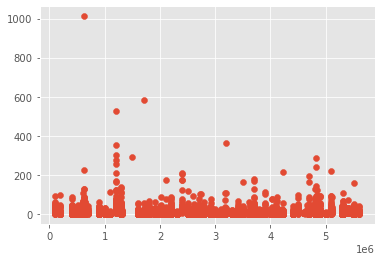

In [7]:
# # Identify and remove outliers
plt.scatter(cluster_df['leaid'], cluster_df['number_of_schools'])

## Somewhat arbitrary threshold of >500 schools
outliers = cluster_df[cluster_df['number_of_schools'] > 1000]
display(outliers)

# print(cluster_df.shape)
cluster_df = cluster_df.drop(outliers.index)
print(cluster_df.shape)

In [8]:
# Remove the columns that won't be used as features
cluster_prepared_df = cluster_df.drop(['leaid', 'year', 'lea_name', 'fips'], axis=1)

In [9]:
# Add log transformed versions of each feature
cluster_prepared_logs_df = cluster_prepared_df.copy(deep=True)
for col in cluster_prepared_logs_df.columns:
    cluster_prepared_logs_df['log_'+col] = cluster_prepared_logs_df[col].apply(lambda x: math.log(x+1))

### Univariate Analysis

***High-Level Overview***


* **[Size Factor]:** The financial and demographic data is heavily dependent on the size of the district.


* **[Normal Distributions]:** Math and reading midpoints are roughly normally distributed. The log transformations of teacher_total_fte, special_ed_students, and enrollment_x are also normally distributed. 


* **[Non-Normal Distributions]:** Notably, number_of_schools is NOT normally distributed even following a log transform. Revenue and Expenditure don't appear to be normally distributed.

In [10]:
# Histograms

# Interactive Scatterplot for Indicators
%matplotlib notebook

metrics = list(cluster_prepared_df.columns)

@interact(metric=metrics)
def hist_metric_explorer(metric):
    # Clear any old figures
    plt.close()
    
    # Make a plot to match states to the chosen metric
    plt.figure(figsize=(6, 4), num='Indicator Explorer Tool')
    plt.hist(cluster_prepared_logs_df[metric], rwidth=0.9)
    plt.title(f'{metric}')
    
interactive_plot = interactive(hist_metric_explorer,
                               metric=metrics[0])

interactive(children=(Dropdown(description='metric', options=('number_of_schools', 'teachers_total_fte', 'spec…

In [11]:
# Scatter Plot

# Interactive Scatterplot for Indicators
%matplotlib notebook

metrics = list(cluster_prepared_df.columns)

@interact(metric=metrics)
def scatter_metric_explorer(metric):
    # Clear any old figures
    plt.close()
    
    # Make a plot to match states to the chosen metric
    plt.figure(figsize=(6, 4), num='Indicator Explorer Tool')
    plt.scatter(cluster_df['leaid'], cluster_prepared_logs_df[metric], alpha=0.5)
    plt.title(f'{metric}')
    
interactive_plot = interactive(scatter_metric_explorer,
                               metric=metrics[0])

interactive(children=(Dropdown(description='metric', options=('number_of_schools', 'teachers_total_fte', 'spec…

In [12]:
# Minimum / Maximums

# Interactive Tables for Indicators
%matplotlib notebook

metrics = list(cluster_prepared_df.columns)

@interact(metric=metrics)
def table_metric_explorer(metric):
    print('Max')
    display(cluster_df.iloc[cluster_prepared_df[metric].argmax()])
    print()
    print('Min')
    display(cluster_df.iloc[cluster_prepared_df[metric].argmin()])
    
interactive_plot = interactive(table_metric_explorer,
                               metric=metrics[0])

interactive(children=(Dropdown(description='metric', options=('number_of_schools', 'teachers_total_fte', 'spec…

### Multivariate Analysis

### Correlation

The purpose of this section is to evaluate the linear relationships that the features have with one another.

***High-Level Overview***


* **[Size Factor]:** The financial and demographic data (previously noted to vary with size), correlate to one another.


* **[Math and Reading]:** Math and Reading mid-points have a correlation of ~0.866.


<IPython.core.display.Javascript object>


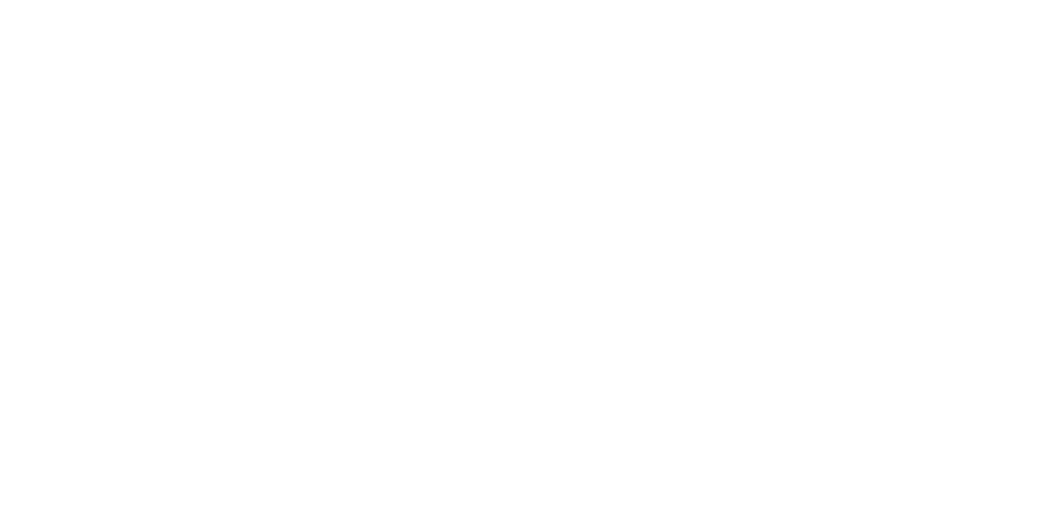

<AxesSubplot:>

In [13]:
# Draw a correlation heatmap
## Uses Seaborn's documentation https://seaborn.pydata.org/examples/many_pairwise_correlations.html

# Compute the correlation matrix
corr = cluster_prepared_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(8,4))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1.0, vmin=-1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [14]:
display(corr)

,number_of_schools,teachers_total_fte,spec_ed_students,enrollment_x,read_test_pct_prof_midpt,math_test_pct_prof_midpt,rev_total,exp_total
number_of_schools,1.000000,0.955013,0.960363,0.969670,0.007939,0.032570,0.949703,0.947678
teachers_total_fte,0.955013,1.000000,0.958155,0.977536,0.038170,0.062176,0.947103,0.946947
spec_ed_students,0.960363,0.958155,1.000000,0.974029,0.012305,0.026871,0.955952,0.952637
enrollment_x,0.969670,0.977536,0.974029,1.000000,0.030393,0.050932,0.958967,0.959042
read_test_pct_prof_midpt,0.007939,0.038170,0.012305,0.030393,1.000000,0.865864,0.028469,0.030363
math_test_pct_prof_midpt,0.032570,0.062176,0.026871,0.050932,0.865864,1.000000,0.042301,0.045069
rev_total,0.949703,0.947103,0.955952,0.958967,0.028469,0.042301,1.000000,0.996673
exp_total,0.947678,0.946947,0.952637,0.959042,0.030363,0.045069,0.996673,1.000000


### Multiple Regression

The purpose of this section is to regress the dataset on each feature as a means of demonstrating interaction.

***High-Level Overview***


* **[number_of_schools]:** Related to spec_ed_students, enrollment_x, and rev_total.


* **[teachers_total_fte]:** Related to enrollment_x.


* **[spec_ed_students]:** Related to enrollment_x, rev_total.


* **[enrollment_x]:** Related to number_of_schools, teachers_total_fte, exp_total.


* **[read_test_pct_prof_midpt]:** Related to math_test_pct_midpt.


* **[math_test_pct_prof_midpt]:** Related to read_test_pct_midpt.


* **[rev_total]:** Related to exp_total.


* **[exp_total]:** Related to rev_total.

In [15]:
# Regressions

# Interactive Regressions for Indicators
%matplotlib notebook

metrics = list(cluster_prepared_df.columns)

@interact(metric=metrics)
def multi_regression_metric_explorer(metric):
    # Clear any old figures
    plt.close()
    
    # Normalize data
    features = cluster_prepared_df.drop(metric, axis=1)
    labels = cluster_prepared_df[metric]

    normed_features = preprocessing.StandardScaler().fit_transform(features)
    normed_labels = preprocessing.StandardScaler().fit_transform(labels.to_numpy().reshape(-1,1))
    
    # Setup a Linear Regression
    lr_model = LinearRegression()
    
    # Fit the regression with the available data
    lr_model.fit(normed_features, normed_labels)
    preds = lr_model.predict(normed_features)
    
    # Visualize the resulting model
    r_2 = round(lr_model.score(normed_features, normed_labels), 3)
    print(f'R^2 Value: {r_2}')
    print()

    mse = round(mean_squared_error(normed_labels, preds), 3)
    print(f'MSE: {mse}')
    print()

    coef_vals = [round(x,3) for x in lr_model.coef_[0]]
    coef_map = list(zip(features.columns, coef_vals))
    print(f'Coefficients:')
    pprint.pprint(coef_map)
    print()

    print(f'Intercept: {lr_model.intercept_}')
    
    # Use statsmodels to get more details
    display(sm.OLS(normed_labels, normed_features).fit().summary())
    
interactive_plot = interactive(multi_regression_metric_explorer,
                               metric=metrics[0])

interactive(children=(Dropdown(description='metric', options=('number_of_schools', 'teachers_total_fte', 'spec…

### Scatter Plot Comparisons

***High-Level Overview***

* **[Log Transformations]:** Attributes dependent on size are easier to visualize when their log-adjusted counterparts are used.


In [16]:
# Scatter Plot

# Interactive Scatterplot for Indicators
%matplotlib notebook

metrics = list(cluster_prepared_logs_df.columns)

@interact(metric1=metrics, metric2=metrics)
def scatter_multi_metric_explorer(metric1, metric2):
    # Clear any old figures
    plt.close()
    
    # Make a plot to match states to the chosen metric
    plt.figure(figsize=(6, 4), num='Indicator Explorer Tool')
    plt.scatter(cluster_prepared_logs_df[metric1], cluster_prepared_logs_df[metric2], alpha=0.5)
    plt.title(f'{metric1} vs. {metric2}')
    
interactive_plot = interactive(scatter_multi_metric_explorer,
                               metric1=metrics[0],
                               metric2=metrics[0])

interactive(children=(Dropdown(description='metric1', options=('number_of_schools', 'teachers_total_fte', 'spe…